In [ ]:
from configparser import ConfigParser

config = ConfigParser()
config.read('config.ini')



In [ ]:
config['model']['num_epochs']

In [3]:
from pathlib import Path
import Augmentation
from AudioDataset import transformData
import torchaudio
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import os
import machineLearning
from model import ResNet18, CNNNetwork, M5
from configparser import ConfigParser
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

if __name__ == '__main__':
    config = ConfigParser()
    config.read('config.ini')

    audio_paths = Augmentation.getAudioPaths('./data/')[0:3]

    test_len = int(
        int(config['data']['train_percent']) / 100 * len(audio_paths))
    audio_train_paths, audio_val_paths = audio_paths[:test_len], audio_paths[
        test_len:]

    transformList = [
        {
            "audio": [
                AddGaussianNoise(min_amplitude=0.001,
                                 max_amplitude=0.015,
                                 p=0.5),
                TimeStretch(min_rate=0.9, max_rate=1.1, p=0.5),
                PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
                Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
            ],
            "spectrogram": []
        },
        {
            "audio": [],
            "spectrogram": [
                torchaudio.transforms.TimeMasking(80),
                torchaudio.transforms.FrequencyMasking(80)
            ],
        },
    ]

    audio_train_dataset = transformData(audio_train_paths, transformList)

    audio_val_dataset = transformData(audio_val_paths)

    print(
        f'Train dataset Length: {len(audio_train_dataset)} ({len(audio_train_paths)} before augmentation)'
    )
    print(f'Validation dataset Length: {len(audio_val_dataset)}')

    train_dataloader = torch.utils.data.DataLoader(
        audio_train_dataset,
        batch_size=int(config['model']['batch_size']),
        num_workers=0,
        shuffle=True,
    )

    val_dataloader = torch.utils.data.DataLoader(
        audio_val_dataset,
        batch_size=int(config['model']['batch_size']),
        num_workers=4,
        shuffle=True)


Train dataset Length: 6 (2 before augmentation)
Validation dataset Length: 1


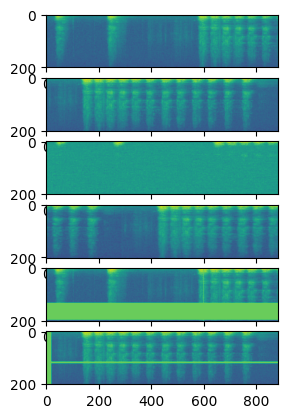

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(audio_train_dataset))

for i, spectrogram in enumerate(audio_train_dataset):
    axs[i].imshow(spectrogram[0][0])